In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras import datasets, utils, callbacks
from tensorflow.keras import layers, models
from tensorflow.keras import optimizers

import tensorflow.keras.backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 오토인코더

In [ ]:
# 패션 mnist 데이터 셋을 통한 오토인코더 구현 실습
from tensorflow.keras import datasets
(X_train, y_train), (X_test, y_test) = datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [ ]:
p = f'''
    X_train.shape = {X_train.shape}
    y_tarin.shape = {y_train.shape}

    X_test.shape = {X_test.shape}
    y_test.shape = {y_test.shape}
'''
print(p)


    X_train.shape = (60000, 28, 28)
    y_tarin.shape = (60000,)
    
    X_test.shape = (10000, 28, 28)
    y_test.shape = (10000,)



In [ ]:
# 전처리
def preprocess(imgs):
    imgs = imgs.astype('float32') / 255.0 # rgb 값의 표준화
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values = 0.0) # pad_width의 두께로 패딩 추가
    imgs = np.expand_dims(imgs, axis = -1) # 차원을 확장하는 기능, axis는 어느 열에 차원을 추가할 것인지를 결정하는 것
    # axis = -1이면, 맨 마지막 열에 차원 추가

    return imgs

In [ ]:
X_train = preprocess(X_train)
X_test = preprocess(X_test)

p = f'''
    X_train.shape = {X_train.shape}
    y_tarin.shape = {y_train.shape}

    X_test.shape = {X_test.shape}
    y_test.shape = {y_test.shape}
'''
print(p)


    X_train.shape = (60000, 32, 32, 1)
    y_tarin.shape = (60000,)
    
    X_test.shape = (10000, 32, 32, 1)
    y_test.shape = (10000,)



In [ ]:
encoder_input = layers.Input(shape = (32, 32, 1), name = 'encoder_input')

x = layers.Conv2D(32, (3, 3), strides = 2, activation = 'relu', padding = 'same')(encoder_input)
x = layers.Conv2D(64, (3, 3), strides = 2, activation = 'relu', padding = 'same')(x)
x = layers.Conv2D(128, (3, 3), strides = 2, activation = 'relu', padding = 'same')(x)
shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)

encoder_output = layers.Dense(2, name = 'encoder_output')(x) # output의 shape = (2, ) 따라서 디코더 input의 shape = (2,)

encoder = models.Model(encoder_input, encoder_output)

In [ ]:
encoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
Total params: 96770 (378.01 KB)
Trainable params: 96770 (37

In [ ]:
decoder_input = layers.Input(shape = (2,), name = 'decoder_input')

x = layers.Dense(np.prod(shape_before_flattening))(decoder_input) # np.prod() - 모든 원소들의 곱을 반환
x = layers.Reshape(shape_before_flattening)(x) # 인코더에서 플랫화하기 전의 데이터 형태로 변경
x = layers.Conv2DTranspose(128, (3, 3), strides = 2, activation = 'relu', padding = 'same')(x)
x = layers.Conv2DTranspose(64, (3, 3), strides = 2, activation = 'relu', padding = 'same')(x)
x = layers.Conv2DTranspose(32, (3, 3), strides = 2, activation = 'relu', padding = 'same')(x)

decoder_output = layers.Conv2D(1,
                               (3, 3),
                               strides = 1,
                               activation = 'sigmoid',
                               padding = 'same',
                               name = 'decoder_output')(x)

decoder = models.Model(decoder_input, decoder_output)

In [ ]:
decoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 2048)              6144      
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 8, 8, 128)         147584    
 Transpose)                                                      
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 32, 32, 32)        1846

In [ ]:
autoencoder = models.Model(encoder_input, decoder(encoder_output))

In [ ]:
autoencoder.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
 model_4 (Functional)        (None, 32, 32, 1)         2462

In [ ]:
autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy')

In [ ]:
autoencoder.fit(X_train,
                X_train,
                epochs = 3,
                batch_size = 100,
                shuffle = True,
                validation_data = (X_test, X_test)) # input 과 output이 같다!!!

Epoch 1/3
600/600 [==============================] - 264s 435ms/step - loss: 0.2959 - val_loss: 0.2657
Epoch 2/3
600/600 [==============================] - 257s 429ms/step - loss: 0.2606 - val_loss: 0.2596
Epoch 3/3
600/600 [==============================] - 251s 419ms/step - loss: 0.2564 - val_loss: 0.2559


손실함수의 선택

- RMSE: 생성된 출력이 평균 픽셀 값을 중심으로 대칭적으로 분포됨을 의미

제곱근 평균에 대해서 오차를 줄이는 작업을 하는 것이니까, 값이 평균 값을 근사하도록 하는 것

- 이진 크로스 엔트로피: 극단적인 오차가 0.5에 가까운 오차보다 훨씬 큰 손실을 만듦 -> 0.5에 가까운 손실을 만듦

In [9]:
pwd

'/content'

In [10]:
drive_path = '/content/drive/MyDrive/Colab Notebooks/data'

In [ ]:
autoencoder.save(f'{drive_path}/autoencoder')
encoder.save(f'{drive_path}/encoder')
decoder.save(f'{drive_path}/decoder')

In [11]:
autoencoder = models.load_model(f'{drive_path}/autoencoder')
encoder = models.load_model(f'{drive_path}/encoder')
decoder = models.load_model(f'{drive_path}/decoder')

In [12]:
# 이미지 재구성
n_to_predict = 5000

example_images = X_test[:n_to_predict]
predictions = autoencoder.predict(example_images)

157/157 [==============================] - 7s 44ms/step


In [13]:
X_test.shape

(10000, 32, 32, 1)

In [14]:
example_images.shape

(5000, 32, 32, 1)

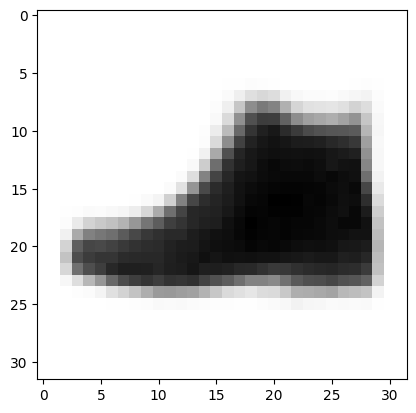

In [15]:
plt.imshow(predictions[28],
           cmap = 'gray_r')

### 잠재 공간 시각화하기

157/157 [==============================] - 1s 6ms/step


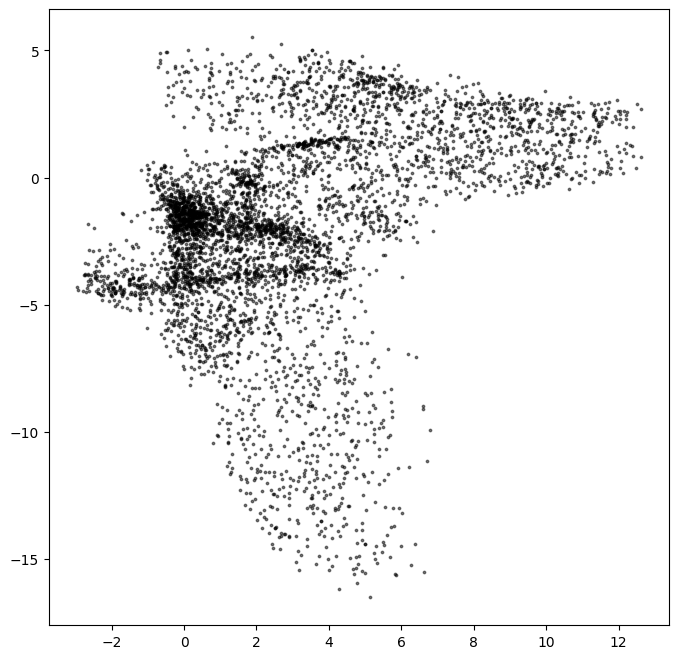

In [16]:
embeddings = encoder.predict(example_images)

plt.figure(figsize = (8, 8))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c = 'black', alpha = 0.5, s = 3)
plt.show()

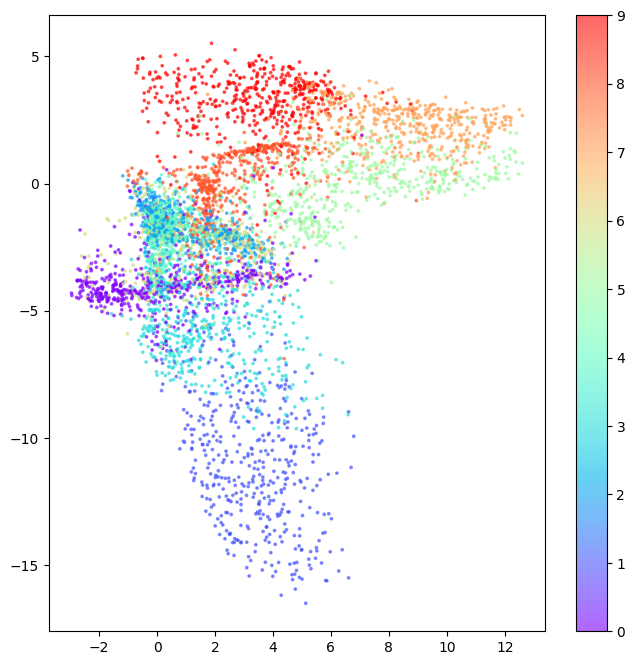

In [17]:
example_labels = y_test[:n_to_predict]

figsize = 8
plt.figure(figsize = (figsize, figsize))
plt.scatter(embeddings[:, 0],
            embeddings[:, 1],
            cmap = 'rainbow',
            c = example_labels,
            alpha = 0.6,
            s = 3)
plt.colorbar()

plt.show()

### 새로운 이미지 생성하기

In [ ]:
mins, maxs = np.min(embeddings, axis = 0), np.max(embeddings, axis = 0)
sample = np.random.uniform(mins, maxs, size = (18, 2))
# 총 18 * 2의 숫자를 뽑는데, (x, y)의 형태로 18개를 뽑는 것

reconstructions = decoder.predict(sample)

1/1 [==============================] - 0s 138ms/step


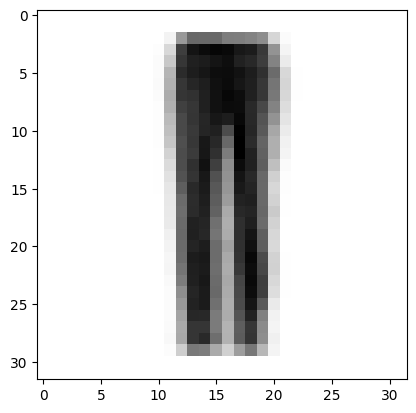

In [ ]:
plt.imshow(reconstructions[5],
           cmap = 'gray_r')

# 변이형 오토인코더

잠재 공간에 있는 포인트 주변의 다변량 정규 분포에 매핑

즉 하나의 포인트가 아닌 점들의 분포에 대해서 인코딩 - 디코딩이 진행되는 것

In [68]:
import tensorflow as tf
from tensorflow.keras import layers, models, datasets, callbacks, losses, optimizers, metrics

from scipy.stats import norm

### 변이형 오토인코더 만들기

In [19]:
class Sampling(layers.Layer): # keras의 레이어층을 입력으로 받는다.
    def call(self, inputs): # call 함수 설정
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape = (batch, dim))

        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

안녕하십니까

1. 캐글 강의코드에서 __call__로 바꾸면 오류가 안나고

call을 하면 정상작동하는데 왜 이런건지 이런지 궁금합니다.

=> keras Layer의 call()과 __call__()은 거의 유사하게 동작합니다.

keras Layer를 Callbable 객체로 만들면 보다 정확하게는 __call__()이 내부적으로 호출이 됩니다. 이 __call__()은 부모 Layer에 감춰져 있기에 작성해줄 필요가 없으며, __call__()이 해주는 것은 build()를 호출한 뒤에 call()을 호출하는 역할을 합니다.

Custom layer에 call()을 사용하지 않고 __call__()을 바로 적용할 수도 있습니다. 하지만 그렇게 하기 위해서는 build()에서 사용된 weight와 bias의 초기화를 한 뒤에 matrix 연산을 적용하고 tensor로 반환하는 로직을 만들어 줘야 합니다.

class CustomDense(tf.keras.layers.Layer):
    # CustomDense 객체 생성시 입력되는 초기화 parameter 처리
    def __init__(self, units=32):
        super(CustomDense, self).__init__()
        self.units = units

    
    def __call__(self, inputs):
        self.w = self.add_weight(
            shape=(inputs.shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )
        return tf.matmul(inputs, self.w) + self.b

# input 값을 4개의 원소를 가지는 1차원으로 생성.
inputs = Input((4,))
# 10개의 unit을 가지는 CustomDense 객체를 생성 후 callable로 inputs값 입력
outputs = CustomDense(10)(inputs)

# inputs와 outputs로 model 생성.
model = Model(inputs, outputs)
model.summary()

In [77]:
encoder_input = layers.Input(shape = (32, 32, 1), name = 'encoder_input')

x = layers.Conv2D(32, (3, 3), strides = 2, activation = 'relu', padding = 'same')(encoder_input)
x = layers.Conv2D(64, (3, 3), strides = 2, activation = 'relu', padding = 'same')(x)
x = layers.Conv2D(128, (3, 3), strides = 2, activation = 'relu', padding = 'same')(x)
shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)

z_mean = layers.Dense(2, name = 'z_mean')(x)
z_log_var = layers.Dense(2, name = 'z_log_var')(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name = 'encoder')

# 인풋 이미지에 대해서 2D 합성곱층을 지난 임베딩 값을 Dense 층에 넣어서 z_mean, z_log_var 값을 추출
# 두 값을 위에서 정의한 Sampling 클래스에 입력하여 z 값 리턴 (정규 분포에 기반하여 샘플링된 값)

In [21]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 8, 8, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 4, 4, 128)            73856     ['conv2d_1[0][0]']            
                                                                                            

In [24]:
decoder_input = layers.Input(shape = (2, ), name = 'decoder_input')

x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128,
                           (3, 3),
                           strides = 2,
                           activation = 'relu',
                           padding = 'same')(x)
x = layers.Conv2DTranspose(64,
                           (3, 3),
                           strides = 2,
                           activation = 'relu',
                           padding = 'same')(x)
x = layers.Conv2DTranspose(32,
                           (3, 3),
                           strides = 2,
                           activation = 'relu',
                           padding = 'same')(x)
decoder_output = layers.Conv2D(1,
                               (3, 3),
                               strides = 1,
                               activation = 'sigmoid',
                               padding = 'same',
                               name = 'decoder_output')(x)

decoder = models.Model(decoder_input, decoder_output)

In [25]:
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 2048)              6144      
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 8, 8, 128)         147584    
 Transpose)                                                      
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 32, 32, 32)        18464 

In [28]:
# 변이형 오토인코더에서는 오토인코더와 다른 손실함수와 최적화 함수를 사용한다.

class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)

        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name = 'total_loss')
        self.reconstruction_loss_tracker = metrics.Mean(name = 'reconstruction_loss')
        self.kl_loss_tracker = metrics.Mean(name = 'kl_loss')

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    def call(self, inputs):
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)

        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(500 * losses.binary_crossentropy(data, reconstruction, axis = (1, 2, 3)))
            kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis = 1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(500 * losses.binary_crossentropy(data, reconstruction, axis = (1, 2, 3)))
        kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis = 1))
        total_loss = reconstruction_loss + kl_loss

        return {'loss': total_loss,
                 'reconstruction_loss': reconstruction_loss,
                 'kl_loss': kl_loss}

    def get_config(self):
        return {}

### 변이형 오토인코더 훈련

In [29]:
vae = VAE(encoder, decoder)
optimizer = optimizers.Adam(learning_rate = 0.0005)
vae.compile(optimizer = optimizer)

In [30]:
vae.fit(X_train,
        epochs = 5,
        batch_size = 100,
        shuffle = True,
        validation_data = (X_test, X_test))

Epoch 1/5
600/600 [==============================] - 244s 402ms/step - total_loss: 142.7795 - reconstruction_loss: 138.0219 - kl_loss: 4.7576 - val_loss: 140.0125 - val_reconstruction_loss: 135.2855 - val_kl_loss: 4.7270
Epoch 2/5
600/600 [==============================] - 238s 397ms/step - total_loss: 135.0586 - reconstruction_loss: 130.1072 - kl_loss: 4.9514 - val_loss: 137.5780 - val_reconstruction_loss: 132.4782 - val_kl_loss: 5.0999
Epoch 3/5
600/600 [==============================] - 235s 392ms/step - total_loss: 133.6502 - reconstruction_loss: 128.6255 - kl_loss: 5.0247 - val_loss: 136.1138 - val_reconstruction_loss: 131.0276 - val_kl_loss: 5.0862
Epoch 4/5
600/600 [==============================] - 246s 409ms/step - total_loss: 132.8397 - reconstruction_loss: 127.7805 - kl_loss: 5.0593 - val_loss: 135.4258 - val_reconstruction_loss: 130.2685 - val_kl_loss: 5.1573
Epoch 5/5
600/600 [==============================] - 239s 399ms/step - total_loss: 132.3071 - reconstruction_loss: 1

In [32]:
vae.save(f'{drive_path}/vae')

### 재구성

In [34]:
def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()


In [33]:
n_to_predict = 5000
example_images = X_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

In [35]:
z_mean, z_log_var, reconstructions = vae.predict(example_images)

157/157 [==============================] - 10s 62ms/step


실제


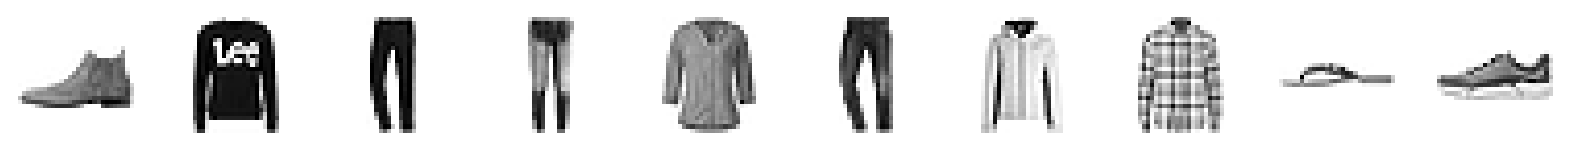

재구성


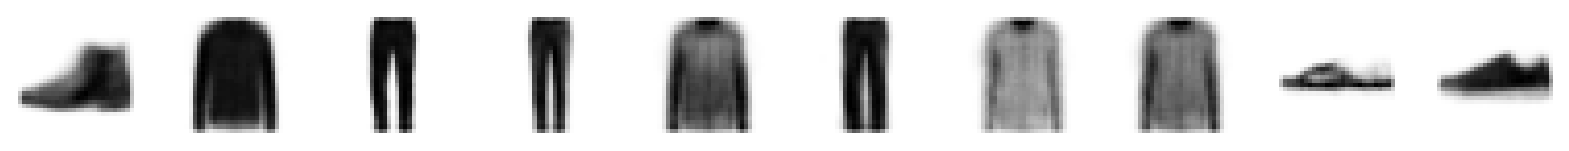

In [36]:
print('실제')
display(example_images)

print('재구성')
display(reconstructions)

### 임베딩 프로세스 확인하기

In [37]:
z_mean, z_var, z = encoder.predict(example_images)

157/157 [==============================] - 2s 15ms/step


In [44]:
z_mean.shape, z_var.shape, z.shape

((5000, 2), (5000, 2), (5000, 2))

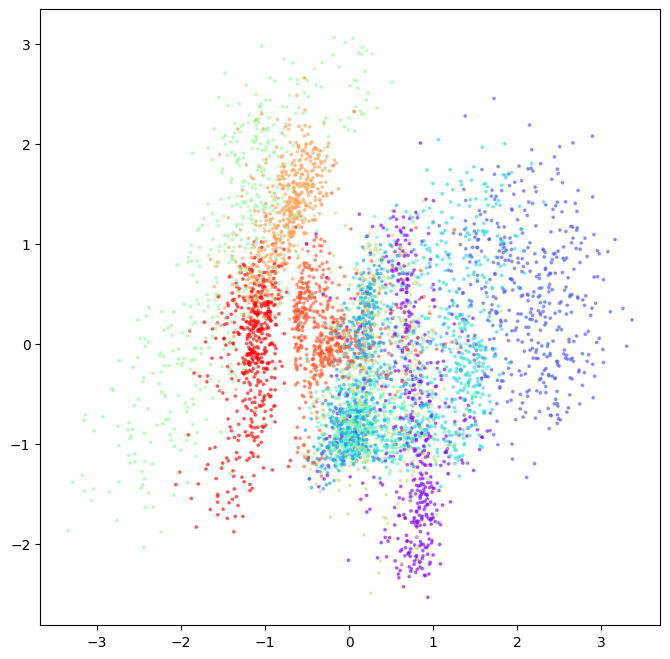

In [46]:
figsize = 8

plt.figure(figsize = (figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], cmap = 'rainbow', c = example_labels, alpha = 0.5, s = 3)
plt.show()

In [47]:
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size = (grid_width * grid_height, 2))

print(z_sample)

[[ 0.70193785  0.11435532]
 [ 0.03802917  1.06767369]
 [ 0.20132222  1.01463048]
 [ 0.95748659  0.41910967]
 [-1.50006208 -0.44064298]
 [-0.98857393 -0.18465052]
 [ 2.07705538 -0.16497551]
 [-0.44978874 -1.21800895]
 [-0.33136616 -1.21307875]
 [-1.44759265 -0.75740834]
 [ 0.9670613   0.43520499]
 [-0.03719408  0.86564821]
 [-0.45061489 -0.65516144]
 [ 1.66795708  1.59126587]
 [-0.92349229  0.16132758]
 [-0.07178878 -0.37915993]
 [-0.12221693 -2.38180878]
 [ 0.47345056  0.06748012]]


In [ ]:
reconstructions = decoder.predict(z_sample)

print(reconstructions.shape, reconstructions)

In [56]:
# p-value 를 계산하는 이유는?

p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

In [ ]:
figsize = 8

plt.figure(figsize = (figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c = 'black', alpha = 0.5, s = 2)

plt.scatter(z_sample[:, 0], z_sample[:, 1], c = '#00B0F0', alpha = 1, s = 40)

plt.show()

fig = plt.figure(figsize = (figsize, grid_height * 2))
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis('off')
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize = 10,
        ha = 'center',
        transform = ax.transAxes
    )
    ax.imshow(reconstructions[i, :, :], cmap = 'Greys')

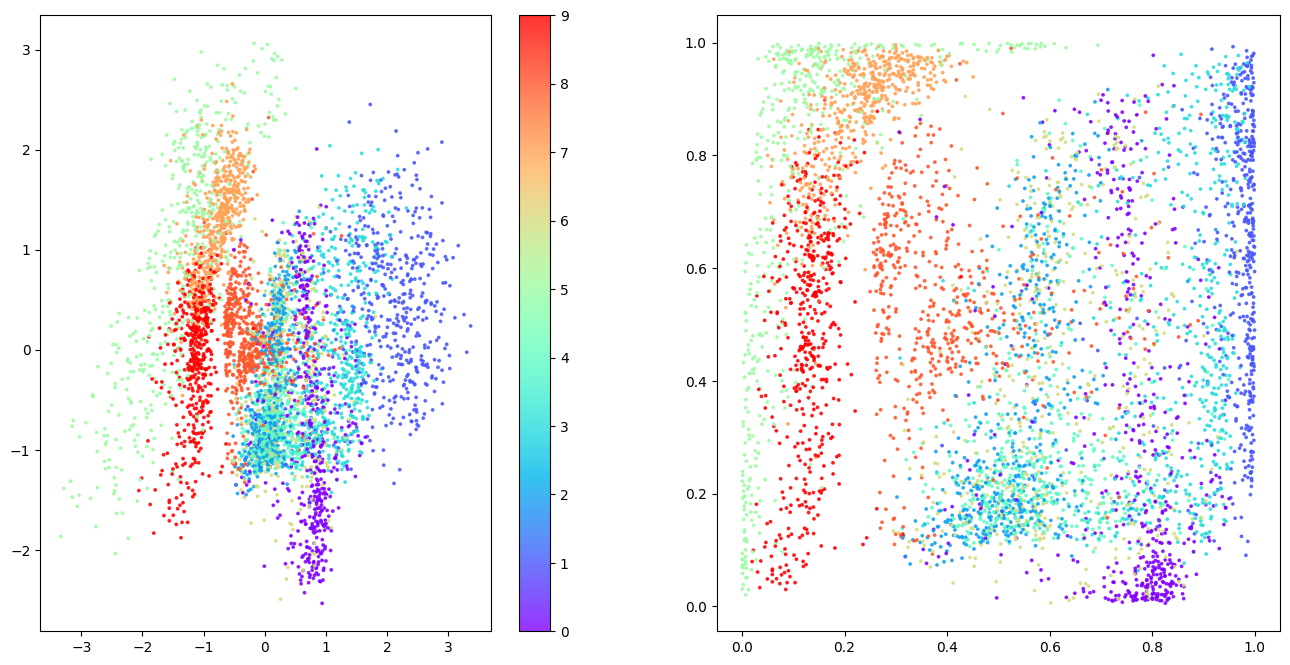

In [61]:
figsize = 8

fig = plt.figure(figsize = (figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap = 'rainbow', c = example_labels, alpha = 0.8, s = 3
)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], cmap = 'rainbow', c = example_labels, alpha = 0.8, s = 3
)

plt.show()

# 잠재 공간 탐색하기